# Normal vs. Cancer AML DESeq2 Analysis

Normal "whole blood" non-cancerous tissue data from GTEx versus AML cancer bone marrow tissue data from TCGA GDC.

TCGA GDC samples are TCGA-AB-2821, TCGA-AB-2828, and TCGA-AB-2839. GTEx samples are N7MS, NFK9, and O5YT.

Two versions of gene expression counts for each sample are used in this notebook, one labelled "PUBLISHED" and the other labelled "REPROCESSED". Published counts are taken from the [GDC Data Portal](https://portal.gdc.cancer.gov/) and [GTEx Portal](https://gtexportal.org/home/). Reprocessed counts are outputs from the RNA-Seq workflow when using each sample's fastq files into [STAR](https://github.com/alexdobin/STAR) to generate gene expression counts.

## Installation and loading of packages and counts files needed
**R version:** 4.2.2

**Bioconductor version:** 3.16 (BiocManager 1.30.19)

List of packages for this notebook:
- dplyr
- tidyverse
- BiocManager
    - DESeq2
    - gplots
    - locfit
    - EnhancedVolcano
    - biomaRt
- devtools
- readxl
- tibble

### Install and load packages

In [1]:
install.packages('devtools')
if (!require("dplyr", quietly = TRUE))
    install.packages("dplyr")
install.packages("tidyverse")
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
# BiocManager::install(version = "3.16")
BiocManager::install('locfit')
BiocManager::install("EnhancedVolcano", dependencies = T)
BiocManager::install("DESeq2", dependencies = T)
BiocManager::install("biomaRt")
BiocManager::install("gplots")


# In the case EnhancedVolcano fails to install using BiocManager, pull the package off of github
if (!require("EnhancedVolcano", quietly = TRUE))
    devtools::install_github('kevinblighe/EnhancedVolcano')

install.packages("readxl")
install.packages("tibble")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


also installing the dependencies ‘bit’, ‘rematch’, ‘bit64’, ‘backports’, ‘blob’, ‘DBI’, ‘gargle’, ‘cellranger’, ‘ids’, ‘timechange’, ‘vroom’, ‘tzdb’, ‘progress’, ‘selectr’, ‘broom’, ‘conflicted’, ‘dbplyr’, ‘dtplyr’, ‘forcats’, ‘googledrive’, ‘googlesheets4’, ‘haven’, ‘hms’, ‘lubridate’, ‘modelr’, ‘readr’, ‘readxl’, ‘reprex’, ‘rvest’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 (2022-10-31)

Installing package(s) 'locfit'

Updating HTML index of packages i

In [2]:
# Import libraries
library("dplyr")
library("readxl")
library("DESeq2")
library("EnhancedVolcano")
library("gplots")
library("tibble")

library("biomaRt")
ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required p

### Load count files
Files containing gene expression counts for the three GDC and three GTEx samples are located in the `reformatted_counts` directory, each are under the `.counts` file type. Files for counts that are published by the GDC and GTEx are labelled as "PUBLISHED" in the file names. Files for counts that are reprocessed by the Bwb RNA-Seq workflow (v32 of GDC's mRNA-Seq pipeline) are labelled as "REPROCESSED" in the file names.

In [3]:
# Get filepaths for raw reprocessed counts and published counts
reprocessed_raw_filelists <- list.files(path = ".", pattern = ".tab", recursive = T, full.names = T)
published_filelists <- list.files(path = ".", pattern = "D.counts", recursive = T, full.names = T)

# Have the sample names for GDC and GTEx be stored in vectors
gdc_samplenames <- c("2821", "2828", "2839")
gtex_samplenames <- c("N7MS", "NFK9", "O5YT")

In [4]:
read.table(file = reprocessed_raw_filelists[1], header = T, sep = "\t")

N_unmapped,X7669731,X7669731.1,X7669731.2
<chr>,<int>,<int>,<int>
N_multimapping,5360864,5360864,5360864
N_noFeature,25977185,41540995,41288308
N_ambiguous,2766544,700613,710087
ENSG00000223972.5,0,0,0
ENSG00000227232.5,62,31,31
ENSG00000278267.1,3,3,0
ENSG00000243485.5,0,0,0
ENSG00000284332.1,0,0,0
ENSG00000237613.2,0,0,0


In [5]:
counts <- list()

# Add reprocessed counts to counts list (.tab files)
for (i in 1:length(reprocessed_raw_filelists)) {
    sample.df <- read.table(file = reprocessed_raw_filelists[i], header = T, sep = "\t")
    sample.df <- sample.df[4:nrow(sample.df),1:2] # Skip the first 4 rows (1st row currently acts as header, so 3 rows skipped), select first 2 columns 
    # Determine the sample origin (GDC or GTEx) and counts header string based on directory name (between "/" and "/"; ie: ./2821/ReadsPerGene.out.tab -> 2821)
    sample.samplename <- gsub(".*[/]([^.]+)[/].*", "\\1", reprocessed_raw_filelists[i])
    if (sample.samplename %in% gdc_samplenames) {
        sample.header <- paste0("GDC", sample.samplename, "counts", "REPROCESSED")
    } else {
        sample.header <- paste0("GTEx", sample.samplename, "counts", "REPROCESSED")
    }
    colnames(sample.df) <- c("genes", sample.header)

    # Remove decimals and numbers after decimals
    sample.df$genes <- sub("\\..*", "", sample.df$genes)
    # Remove any duplicate listed genes
    sample.df <- sample.df %>% distinct(genes, .keep_all = T)
    # sort genes alphabetically
    sample.df <- sample.df[order(sample.df$genes),]
    
    counts[[i]] <- sample.df
    names(counts)[i] <- sample.header
}

# Add published counts to counts list
for (i in 1:length(published_filelists)) {
    sample.df <- read.table(file = published_filelists[i], header = T, sep = "\t")

    # Remove decimals and numbers after decimals
    sample.df$genes <- sub("\\..*", "", sample.df$genes)
    # Remove any duplicate listed genes
    sample.df <- sample.df %>% distinct(genes, .keep_all = T)
    # sort genes alphabetically
    sample.df <- sample.df[order(sample.df$genes),]
    
    counts[[length(counts)+1]] <- sample.df # append to end of list
    names(counts)[length(counts)] <- colnames(sample.df)[2] # 2nd column header as dataframe name in list
}

In [6]:
# Store GDC and GTEx counts separately, as well as whether they are published or reprocessed counts

gdc.counts <-counts[grep("GDC", names(counts))]
gtex.counts <-counts[grep("GTEx", names(counts))]

# Select Published GDC counts
gdc.published.counts <-gdc.counts[grep("PUBLISHED", names(gdc.counts))]

# Select Reprocessed GDC counts
gdc.reprocessed.counts <-gdc.counts[grep("REPROCESSED", names(gdc.counts))]

# Select Published GTEx counts
gtex.published.counts <-gtex.counts[grep("PUBLISHED", names(gtex.counts))]

# Select Reprocessed GTEx counts
gtex.reprocessed.counts <-gtex.counts[grep("REPROCESSED", names(gtex.counts))]

In [7]:
gdc.published.counts$GDC2821countsPUBLISHED

,genes,GDC2821countsPUBLISHED
,<chr>,<int>
1,ENSG00000000003,48
2,ENSG00000000005,0
3,ENSG00000000419,450
4,ENSG00000000457,767
5,ENSG00000000460,669
6,ENSG00000000938,2838
7,ENSG00000000971,1959
8,ENSG00000001036,611
9,ENSG00000001084,1868


### Load genes file

A dataframe of ENSEMBL genes and their corresponding gene symbols.

In [8]:
# Get gene list of ensembl and symbol from csv
genes.df <- read.csv(file = "Gencode.v36.gene.ensembl.and.symbols.csv", header = T, sep = ",")
colnames(genes.df)[1] <- "gene"
genes.df

gene,symbol
<chr>,<chr>
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112
ENSG00000000938,FGR
ENSG00000000971,CFH
ENSG00000001036,FUCA2
ENSG00000001084,GCLC


## GTEx reprocessed vs GDC reprocessed DESeq2 analysis

### Functions for analysis

In [10]:
# A function to select subset of dataframes to analyze in DESeq2.
# Usually comparisons of GTEx and GDC made, just select either published or reprocessed counts.
# Inputs are two subsets of counts based on eith GTEx or GDC, and published or reprocessed.
# Returns one dataframe containing GTEx and GDC samples aand their counts, genes listed as row names.
createDataframe <- function(dfList1, dfList2) {
    # Combine GTEx and GDC dataframes to one list
    counts.combined <- c(dfList1, dfList2)

    # Merge all dataframes in list into one dataframe based on "genes" column (non-overlapping genes removed)
    counts.combined.df <- Reduce(function(...) merge(..., by = 'genes'), counts.combined)

    # Remove any duplicate listed genes
    counts.combined.df <- counts.combined.df %>% distinct(genes, .keep_all = T)

    # Make genes column as row names, remove from dataframe
    dimnames(counts.combined.df)[[1]] <- counts.combined.df[,1]
    counts.combined.df <- counts.combined.df[, -1]
    
    return(counts.combined.df)
}

# A function to create annotation dataframe from dataframe input, returns the annotation dataframe.
# Returns one dataframe containing the sample and their condition for DESeq2, "meta" dataframe
createAnnotations <- function(df) {
    colName <- colnames(df)
    condition <- vector()
    for (col in colName) {
        if (grepl("GDC", col, fixed = T)) {
            # column is GDC, label as "disease"
            condition <- append(condition, "disease")
        } else {
            # column is GTEx, label as "normal"
            condition <- append(condition, "normal")
        }
    }
    
    return(data.frame(colName, condition))
}
                                 
# A function to get DESEQDataSet (dds) and perform DESeq on it, returns the dds after DESeq
# Inputs are the counts dataframe and meta dataframe
# Returns DESEQDataSet output and perform DESeq on it
performDeseq <- function(countDf, metaDf) {
    dds <- DESeqDataSetFromMatrix(countData = round(countDf), colData = metaDf, design= ~ condition)
    
    # Default factoring for condition is alphabetical, but it'll treat "disease" as the wild type...
    # Set the level as "normal" being first, then "disease" (wild type FIRST vs. altered SECOND)
    dds$condition <- factor(dds$condition, levels = c("normal", "disease"))
    
    # Do DESeq
    dds <- DESeq(dds)
    return(dds)
}

# Function to create a dataframe DESeq2 results that includes gene symbols
dds.res_symbols <- function(dds_res) {
    # Make a version with gene symbols instead of ENSEMBL
    dds_res_symbols <- as.data.frame(dds_res)

    # Set row names (gene) as a column
    dds_res_symbols <- tibble::rownames_to_column(dds_res_symbols, "gene")

    # Get the gene symbols as a column (match by ENSEMBL gene row position)
    dds_res_symbols <- merge(dds_res_symbols, genes.df, by = "gene", all.x = T)
    return(dds_res_symbols)
}


### Select Reprocessed counts for both GTEx and GDC

In [11]:
# Combine counts for all six samples into one dataframe
gtex_reprocessedVSgdc_reprocessed_counts.df <- createDataframe(gtex.reprocessed.counts, gdc.reprocessed.counts)

head(gtex_reprocessedVSgdc_reprocessed_counts.df)

,GTExN7MScountsREPROCESSED,GTExNFK9countsREPROCESSED,GTExO5YTcountsREPROCESSED,GDC2821countsREPROCESSED,GDC2828countsREPROCESSED,GDC2839countsREPROCESSED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,17,34,48,6,5
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,88,244,899,454,914,687
ENSG00000000457,106,130,585,768,669,992
ENSG00000000460,47,37,89,669,618,591
ENSG00000000938,10474,9488,94273,2852,11302,975


In [12]:
dim(gtex_reprocessedVSgdc_reprocessed_counts.df)

[1] 60616     6

### DESeq2 setup

In [13]:
# Setup meta annotation table for DESeq2 (label which sample is normal or diseased/cancerous)
gtex_reprocessedVSgdc_reprocessed_counts.df.meta <- createAnnotations(gtex_reprocessedVSgdc_reprocessed_counts.df)
gtex_reprocessedVSgdc_reprocessed_counts.df.meta

colName,condition
<chr>,<chr>
GTExN7MScountsREPROCESSED,normal
GTExNFK9countsREPROCESSED,normal
GTExO5YTcountsREPROCESSED,normal
GDC2821countsREPROCESSED,disease
GDC2828countsREPROCESSED,disease
GDC2839countsREPROCESSED,disease


### Perform DESeq2, alpha set to 0.01

In [14]:
# Get DESEQDataSet (dds) and perform DESeq on it
gtex_reprocessedVSgdc_reprocessed_counts.dds <- performDeseq(gtex_reprocessedVSgdc_reprocessed_counts.df, gtex_reprocessedVSgdc_reprocessed_counts.df.meta)

# Get the result from DESeq2 into dataframe, alpha = 0.01
gtex_reprocessedVSgdc_reprocessed_counts.dds.res <- results(gtex_reprocessedVSgdc_reprocessed_counts.dds, alpha = 0.01)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [15]:
# print results from DESeq2
gtex_reprocessedVSgdc_reprocessed_counts.dds.res

log2 fold change (MLE): condition disease vs normal 
Wald test p-value: condition disease vs normal 
DataFrame with 60616 rows and 6 columns
                 baseMean log2FoldChange     lfcSE        stat      pvalue
                <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000003   19.1862    -1.53809205  1.154733 -1.33198930 1.82864e-01
ENSG00000000005    0.0000             NA        NA          NA          NA
ENSG00000000419  490.6200    -0.80238405  0.726515 -1.10442929 2.69407e-01
ENSG00000000457  421.1977     0.00415899  0.605216  0.00687191 9.94517e-01
ENSG00000000460  212.3298     1.69189533  0.399018  4.24014433 2.23376e-05
...                   ...            ...       ...         ...         ...
ENSG00000288669  0.177322      0.0525164  4.035079    0.013015    0.989616
ENSG00000288670 88.775567      0.6628576  0.705164    0.940005    0.347215
ENSG00000288671  0.000000             NA        NA          NA          NA
ENSG00000288674  6.729081      2.1

In [16]:
# Get number of genes with p-adjusted value under 0.01
sum(gtex_reprocessedVSgdc_reprocessed_counts.dds.res$padj < 0.01, na.rm = T)

# out of how many genes for the 6 samples
dim(gtex_reprocessedVSgdc_reprocessed_counts.df)

[1] 6178

[1] 60616     6

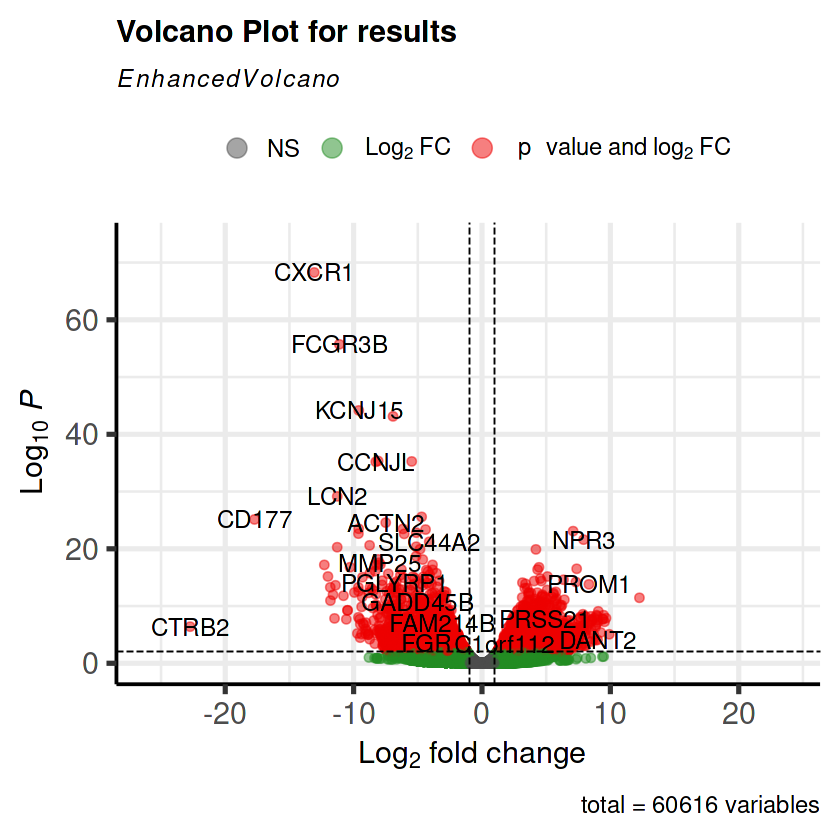

In [17]:
# Version with gene symbols
gtex_reprocessedVSgdc_reprocessed_counts.dds.res_symbols <- dds.res_symbols(gtex_reprocessedVSgdc_reprocessed_counts.dds.res)

# Make a volcano plot for results
EnhancedVolcano(gtex_reprocessedVSgdc_reprocessed_counts.dds.res_symbols,
    lab = gtex_reprocessedVSgdc_reprocessed_counts.dds.res_symbols$symbol,
    title = "Volcano Plot for results",
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.01)

## GTEx Published vs. GDC Reprocessed counts

(Repeated steps from above)

### Select counts for both GTEx and GDC

In [18]:
gtex_publishedVSgdc_reprocessed_counts.df <- createDataframe(gtex.published.counts, gdc.reprocessed.counts)

head(gtex_publishedVSgdc_reprocessed_counts.df)

,GTExN7MScountsPUBLISHED,GTExNFK9countsPUBLISHED,GTExO5YTcountsPUBLISHED,GDC2821countsREPROCESSED,GDC2828countsREPROCESSED,GDC2839countsREPROCESSED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,4,32,47,48,6,5
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,125,406,1618,454,914,687
ENSG00000000457,201,242,1179,768,669,992
ENSG00000000460,73,65,139,669,618,591
ENSG00000000938,16696,15785,167865,2852,11302,975


In [19]:
dim(gtex_publishedVSgdc_reprocessed_counts.df)

[1] 55617     6

### DESeq2 setup

In [20]:
gtex_publishedVSgdc_reprocessed_counts.df.meta <- createAnnotations(gtex_publishedVSgdc_reprocessed_counts.df)
gtex_publishedVSgdc_reprocessed_counts.df.meta

colName,condition
<chr>,<chr>
GTExN7MScountsPUBLISHED,normal
GTExNFK9countsPUBLISHED,normal
GTExO5YTcountsPUBLISHED,normal
GDC2821countsREPROCESSED,disease
GDC2828countsREPROCESSED,disease
GDC2839countsREPROCESSED,disease


In [21]:
# Get DESEQDataSet (dds) and perform DESeq on it
gtex_publishedVSgdc_reprocessed_counts.dds <- performDeseq(gtex_publishedVSgdc_reprocessed_counts.df, gtex_publishedVSgdc_reprocessed_counts.df.meta)

# Get the result from DESeq2 into dataframe
gtex_publishedVSgdc_reprocessed_counts.dds.res <- results(gtex_publishedVSgdc_reprocessed_counts.dds, alpha = 0.01)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [22]:
gtex_publishedVSgdc_reprocessed_counts.dds.res

log2 fold change (MLE): condition disease vs normal 
Wald test p-value: condition disease vs normal 
DataFrame with 55617 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003   24.1272      -1.467922  1.133755 -1.294743 1.95409e-01
ENSG00000000005    0.0000             NA        NA        NA          NA
ENSG00000000419  637.8982      -0.784151  0.769653 -1.018838 3.08280e-01
ENSG00000000457  587.6788      -0.168201  0.622285 -0.270296 7.86932e-01
ENSG00000000460  274.2268       1.778888  0.386731  4.599801 4.22894e-06
...                   ...            ...       ...       ...         ...
ENSG00000284592  0.000000             NA        NA        NA          NA
ENSG00000284594  0.799695        2.61462   2.95634  0.884412    0.376474
ENSG00000284595  0.000000             NA        NA        NA          NA
ENSG00000284596  0.000000             NA        NA      

In [23]:
sum(gtex_publishedVSgdc_reprocessed_counts.dds.res$padj < 0.01, na.rm = T)

# out of...
dim(gtex_publishedVSgdc_reprocessed_counts.df)

[1] 8866

[1] 55617     6

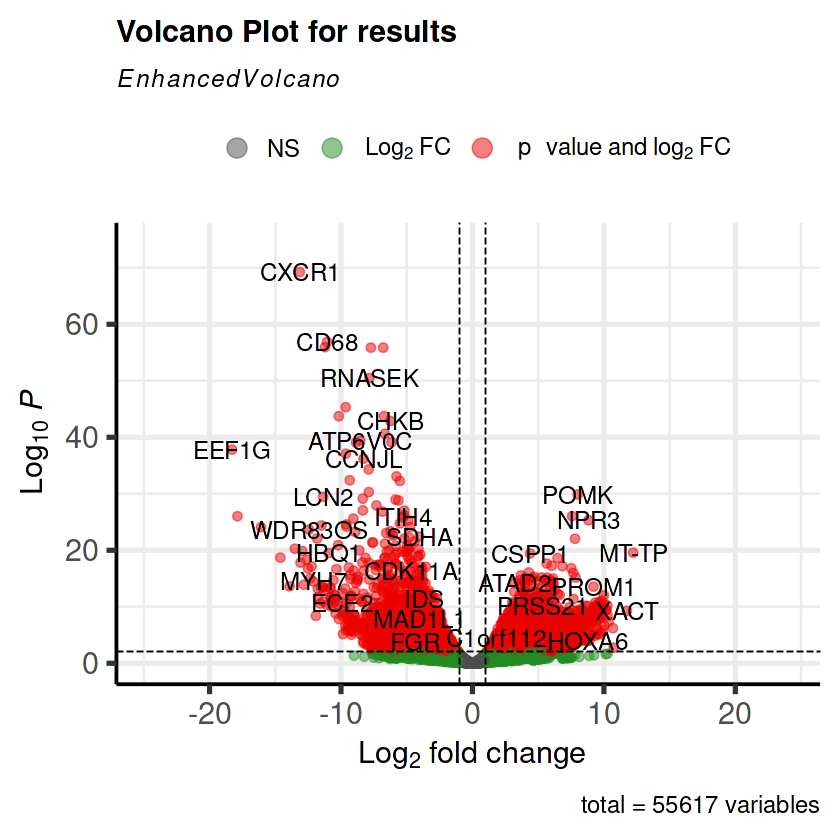

In [24]:
# Version with gene symbols
gtex_publishedVSgdc_reprocessed_counts.dds.res_symbols <- dds.res_symbols(gtex_publishedVSgdc_reprocessed_counts.dds.res)

# Make a volcano plot for results
EnhancedVolcano(gtex_publishedVSgdc_reprocessed_counts.dds.res_symbols,
    lab = gtex_publishedVSgdc_reprocessed_counts.dds.res_symbols$symbol,
    title = "Volcano Plot for results",
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.01)

## GTEx Published vs GDC Published


### Select counts for both GTEx and GDC

In [25]:
gtex_publishedVSgdc_published_counts.df <- createDataframe(gtex.published.counts, gdc.published.counts)

head(gtex_publishedVSgdc_published_counts.df)

,GTExN7MScountsPUBLISHED,GTExNFK9countsPUBLISHED,GTExO5YTcountsPUBLISHED,GDC2821countsPUBLISHED,GDC2828countsPUBLISHED,GDC2839countsPUBLISHED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,4,32,47,48,6,4
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,125,406,1618,450,913,686
ENSG00000000457,201,242,1179,767,667,988
ENSG00000000460,73,65,139,669,616,593
ENSG00000000938,16696,15785,167865,2838,11232,967


In [26]:
dim(gtex_publishedVSgdc_published_counts.df)

[1] 55617     6

#### DESeq2 setup

In [27]:
gtex_publishedVSgdc_published_counts.df.meta <- createAnnotations(gtex_publishedVSgdc_published_counts.df)
gtex_publishedVSgdc_published_counts.df.meta

colName,condition
<chr>,<chr>
GTExN7MScountsPUBLISHED,normal
GTExNFK9countsPUBLISHED,normal
GTExO5YTcountsPUBLISHED,normal
GDC2821countsPUBLISHED,disease
GDC2828countsPUBLISHED,disease
GDC2839countsPUBLISHED,disease


In [28]:
# Get DESEQDataSet (dds) and perform DESeq on it
gtex_publishedVSgdc_published_counts.dds <- performDeseq(gtex_publishedVSgdc_published_counts.df, gtex_publishedVSgdc_published_counts.df.meta)

# Get the result from DESeq2 into dataframe
gtex_publishedVSgdc_published_counts.dds.res <- results(gtex_publishedVSgdc_published_counts.dds, alpha = 0.01)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [29]:
gtex_publishedVSgdc_published_counts.dds.res

log2 fold change (MLE): condition disease vs normal 
Wald test p-value: condition disease vs normal 
DataFrame with 55617 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003    23.971      -1.490138  1.156914 -1.288028 1.97736e-01
ENSG00000000005     0.000             NA        NA        NA          NA
ENSG00000000419   636.678      -0.780140  0.770206 -1.012897 3.11109e-01
ENSG00000000457   586.496      -0.164916  0.622455 -0.264944 7.91053e-01
ENSG00000000460   274.530       1.786322  0.390776  4.571223 4.84885e-06
...                   ...            ...       ...       ...         ...
ENSG00000284592  0.000000             NA        NA        NA          NA
ENSG00000284594  0.802149        2.62302   2.98703  0.878138    0.379869
ENSG00000284595  0.000000             NA        NA        NA          NA
ENSG00000284596  0.000000             NA        NA      

In [30]:
sum(gtex_publishedVSgdc_published_counts.dds.res$padj < 0.01, na.rm = T)

# out of...
dim(gtex_publishedVSgdc_published_counts.df)

[1] 8697

[1] 55617     6

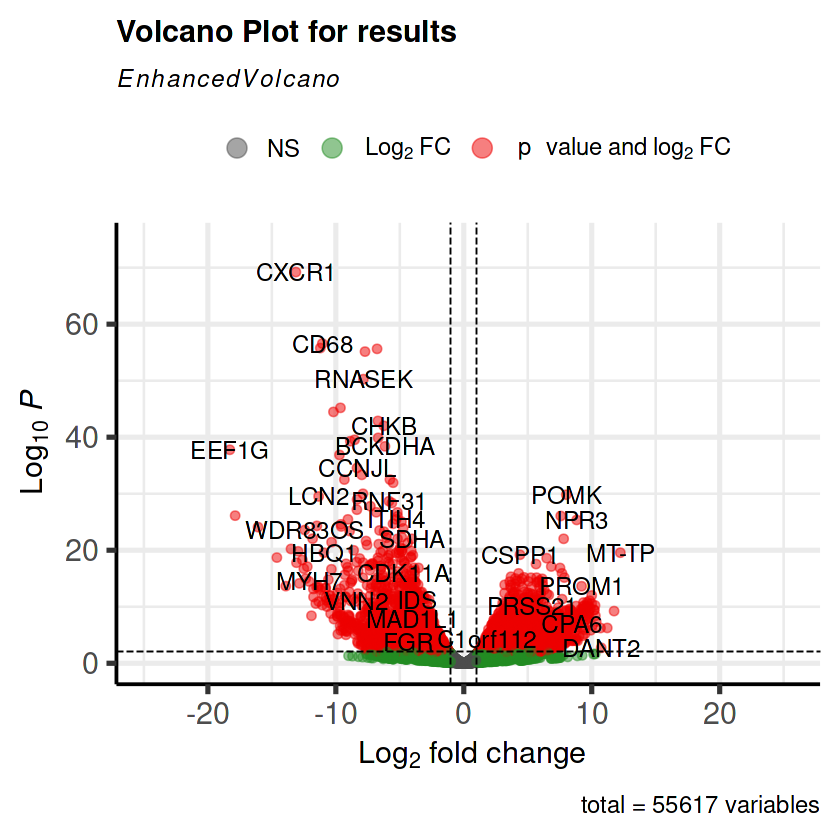

In [31]:
# Version with gene symbols
gtex_publishedVSgdc_published_counts.dds.res_symbols <- dds.res_symbols(gtex_publishedVSgdc_published_counts.dds.res)

# Make a volcano plot for results
EnhancedVolcano(gtex_publishedVSgdc_published_counts.dds.res_symbols,
    lab = gtex_publishedVSgdc_published_counts.dds.res_symbols$symbol,
    title = "Volcano Plot for results",
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.01)

## GTEx Published vs GTEx Reprocessed

In [32]:
gtex_publishedVSgtex_reprocessed_counts.df <- createDataframe(gtex.published.counts, gtex.reprocessed.counts)

head(gtex_publishedVSgtex_reprocessed_counts.df)

,GTExN7MScountsPUBLISHED,GTExNFK9countsPUBLISHED,GTExO5YTcountsPUBLISHED,GTExN7MScountsREPROCESSED,GTExNFK9countsREPROCESSED,GTExO5YTcountsREPROCESSED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,4,32,47,2,17,34
ENSG00000000005,0,0,0,0,0,0
ENSG00000000419,125,406,1618,88,244,899
ENSG00000000457,201,242,1179,106,130,585
ENSG00000000460,73,65,139,47,37,89
ENSG00000000938,16696,15785,167865,10474,9488,94273


In [33]:
dim(gtex_publishedVSgtex_reprocessed_counts.df)

[1] 55617     6

In [34]:
# Make meta dataframe for this comparison
colName <- colnames(gtex_publishedVSgtex_reprocessed_counts.df)
condition <- vector()
for (col in colName) {
    if (grepl("PUBLISHED", col, fixed = T)) {
        # column is PUBLISHED, label as "published"
        condition <- append(condition, "published")
    } else {
        # column is REPROCESSED, label as "reprocessed"
        condition <- append(condition, "reprocessed")
    }
}

gtex_publishedVSgtex_reprocessed_counts.df.meta <- data.frame(colName, condition)
gtex_publishedVSgtex_reprocessed_counts.df.meta

colName,condition
<chr>,<chr>
GTExN7MScountsPUBLISHED,published
GTExNFK9countsPUBLISHED,published
GTExO5YTcountsPUBLISHED,published
GTExN7MScountsREPROCESSED,reprocessed
GTExNFK9countsREPROCESSED,reprocessed
GTExO5YTcountsREPROCESSED,reprocessed


In [35]:
# A function to get DESEQDataSet (dds) and perform DESeq on it, returns the dds after DESeq (GTEx published vs reprocessed edition)
# Inputs are the counts dataframe and meta dataframe
# Returns DESEQDataSet output and perform DESeq on it
performDeseq_gtexpubvsrep <- function(countDf, metaDf) {
    dds <- DESeqDataSetFromMatrix(countData = round(countDf), colData = metaDf, design= ~ condition)
    
    # Set the level as "published" being first, then "reprocessed"
    dds$condition <- factor(dds$condition, levels = c("published", "reprocessed"))
    
    # Do DESeq
    dds <- DESeq(dds)
    return(dds)
}

In [36]:
# Get DESEQDataSet (dds) and perform DESeq on it
gtex_publishedVSgtex_reprocessed_counts.dds <- performDeseq_gtexpubvsrep(gtex_publishedVSgtex_reprocessed_counts.df, gtex_publishedVSgtex_reprocessed_counts.df.meta)

# Get the result from DESeq2 into dataframe
gtex_publishedVSgtex_reprocessed_counts.dds.res <- results(gtex_publishedVSgtex_reprocessed_counts.dds, alpha = 0.01)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [37]:
gtex_publishedVSgtex_reprocessed_counts.dds.res

log2 fold change (MLE): condition reprocessed vs published 
Wald test p-value: condition reprocessed vs published 
DataFrame with 55617 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat    pvalue
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000000003   19.5712    -0.01816188  1.081403 -0.0167947  0.986600
ENSG00000000005    0.0000             NA        NA         NA        NA
ENSG00000000419  433.8215    -0.08491260  0.843193 -0.1007036  0.919786
ENSG00000000457  313.4962    -0.27670716  0.695634 -0.3977771  0.690794
ENSG00000000460   68.3305    -0.00742915  0.496849 -0.0149525  0.988070
...                   ...            ...       ...        ...       ...
ENSG00000284592   0.00000             NA        NA         NA        NA
ENSG00000284594   1.02101       3.804321   3.96403  0.9597101  0.337201
ENSG00000284595   0.00000             NA        NA         NA        NA
ENSG00000284596   0.00000             NA        NA   

In [38]:
sum(gtex_publishedVSgtex_reprocessed_counts.dds.res$padj < 0.01, na.rm = T)

# out of...
dim(gtex_publishedVSgtex_reprocessed_counts.df)

[1] 490

[1] 55617     6

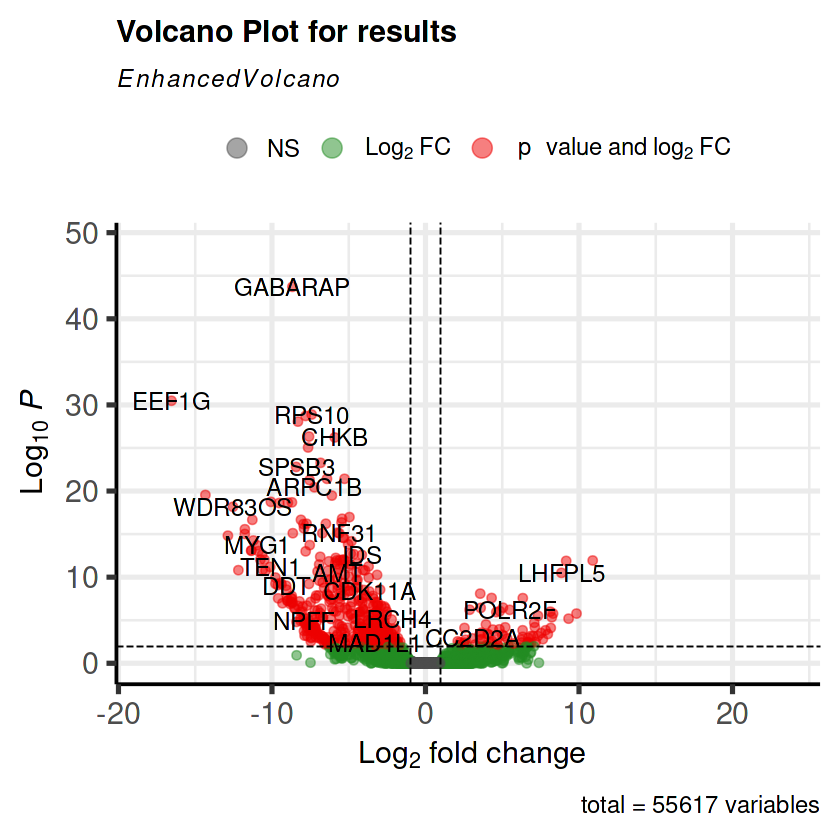

In [39]:
# Version with gene symbols
gtex_publishedVSgtex_reprocessed_counts.dds.res_symbols <- dds.res_symbols(gtex_publishedVSgtex_reprocessed_counts.dds.res)

# Make a volcano plot for results
EnhancedVolcano(gtex_publishedVSgtex_reprocessed_counts.dds.res_symbols,
    lab = gtex_publishedVSgtex_reprocessed_counts.dds.res_symbols$symbol,
    title = "Volcano Plot for results",
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.01)

## Export differentially expressed genes from these 4 DESeq2 analyses into txt files

gtex_reprocessedVSgdc_reprocessed_counts.dds.res

gtex_publishedVSgdc_reprocessed_counts.dds.res

gtex_publishedVSgdc_published_counts.dds.res

gtex_publishedVSgtex_reprocessed_counts.dds.res

In [40]:
# Convert four DESeq2 results as dataframes, sorted padj value in ascending order
gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df <- as.data.frame(gtex_reprocessedVSgdc_reprocessed_counts.dds.res[order(gtex_reprocessedVSgdc_reprocessed_counts.dds.res$padj),])
gtex_publishedVSgdc_reprocessed_counts.dds.res.df <- as.data.frame(gtex_publishedVSgdc_reprocessed_counts.dds.res[order(gtex_publishedVSgdc_reprocessed_counts.dds.res$padj),])
gtex_publishedVSgdc_published_counts.dds.res.df <- as.data.frame(gtex_publishedVSgdc_published_counts.dds.res[order(gtex_publishedVSgdc_published_counts.dds.res$padj),])
gtex_publishedVSgtex_reprocessed_counts.dds.res.df <- as.data.frame(gtex_publishedVSgtex_reprocessed_counts.dds.res[order(gtex_publishedVSgtex_reprocessed_counts.dds.res$padj),])

# Get list of differentially expressed genes for each result
gtex_reprocessedVSgdc_reprocessed.difexpgenes <- rownames(filter(gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df, padj < 0.01))
gtex_publishedVSgdc_reprocessed.difexpgenes <- rownames(filter(gtex_publishedVSgdc_reprocessed_counts.dds.res.df, padj < 0.01))
gtex_publishedVSgdc_published.difexpgenes <- rownames(filter(gtex_publishedVSgdc_published_counts.dds.res.df, padj < 0.01))
gtex_publishedVSgtex_reprocessed.difexpgenes <- rownames(filter(gtex_publishedVSgtex_reprocessed_counts.dds.res.df, padj < 0.01))

# Write genes into txt files
if (!dir.exists('outputs')) {
    dir.create('outputs')
}
write.table(x = gtex_reprocessedVSgdc_reprocessed.difexpgenes, file = "outputs/GTEx Reprocessed vs GDC Reprocessed diff expressed genes ensembl.txt", quote = F, sep = "\n", row.names = F, col.names = F)
write.table(x = gtex_publishedVSgdc_reprocessed.difexpgenes, file = "outputs/GTEx Published vs GDC Reprocessed diff expressed genes ensembl.txt", quote = F, sep = "\n", row.names = F, col.names = F)
write.table(x = gtex_publishedVSgdc_published.difexpgenes, file = "outputs/GTEx Published vs GDC Published diff expressed genes ensembl.txt", quote = F, sep = "\n", row.names = F, col.names = F)
write.table(x = gtex_publishedVSgtex_reprocessed.difexpgenes, file = "outputs/GTEx Published vs GTEx Reprocessed diff expressed genes ensembl.txt", quote = F, sep = "\n", row.names = F, col.names = F)

### Convert Ensembl genes names to symbols, then output their symbols into text files

Conversion used is https://www.syngoportal.org/convert. Output from syngoportal lists ensembl in alphabetical order (rather than lowest to highest padj value in the original listing). Output is downloaded as an excel workfsheet. Getting the output in the correct order is done below.

In [41]:
# Use biomaRt to get gene symbols
gtex_reprocessedVSgdc_reprocessed.difexpgenes.symbol <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", "hgnc_symbol"), values = gtex_reprocessedVSgdc_reprocessed.difexpgenes, mart = ensembl)
gtex_publishedVSgdc_reprocessed.difexpgenes.symbol <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", "hgnc_symbol"), values = gtex_publishedVSgdc_reprocessed.difexpgenes, mart = ensembl)
gtex_publishedVSgdc_published.difexpgenes.symbol <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", "hgnc_symbol"), values = gtex_publishedVSgdc_published.difexpgenes, mart = ensembl)
gtex_publishedVSgtex_reprocessed.difexpgenes.symbol <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", "hgnc_symbol"), values = gtex_publishedVSgtex_reprocessed.difexpgenes, mart = ensembl)


In [42]:
gtex_reprocessedVSgdc_reprocessed.difexpgenes.symbol
gtex_publishedVSgdc_reprocessed.difexpgenes.symbol
gtex_publishedVSgdc_published.difexpgenes.symbol
gtex_publishedVSgtex_reprocessed.difexpgenes.symbol

ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000000460,C1orf112
ENSG00000000938,FGR
ENSG00000001629,ANKIB1
ENSG00000001631,KRIT1
ENSG00000002016,RAD52
ENSG00000003987,MTMR7
ENSG00000004059,ARF5
ENSG00000004660,CAMKK1
ENSG00000004776,HSPB6


ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000000460,C1orf112
ENSG00000000938,FGR
ENSG00000001629,ANKIB1
ENSG00000002016,RAD52
ENSG00000002330,BAD
ENSG00000002822,MAD1L1
ENSG00000003987,MTMR7
ENSG00000004059,ARF5
ENSG00000004660,CAMKK1


ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000000460,C1orf112
ENSG00000000938,FGR
ENSG00000001629,ANKIB1
ENSG00000002016,RAD52
ENSG00000002330,BAD
ENSG00000002822,MAD1L1
ENSG00000003987,MTMR7
ENSG00000004059,ARF5
ENSG00000004660,CAMKK1


ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000002822,MAD1L1
ENSG00000008128,CDK11A
ENSG00000010404,IDS
ENSG00000014138,POLA2
ENSG00000033050,ABCF2
ENSG00000042429,MED17
ENSG00000048342,CC2D2A
ENSG00000055955,ITIH4
ENSG00000062582,MRPS24


### Listing out top 10 differentially-expressed genes for GTEx Reprocessed vs GDC Reprocessed and GTEx Published vs GDC Published

Results of the top 10 DEGs between the two results are summarized externally in Excel

In [43]:
# Print out dataframes of the two results (padj values copied manually)
gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df
gtex_publishedVSgdc_published_counts.dds.res.df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000163464,32075.6117,-13.069742,0.7198513,-18.156170,1.147564e-73,5.261007e-69
ENSG00000162747,13543.9627,-11.117781,0.6758312,-16.450529,8.313956e-61,1.905767e-56
ENSG00000157551,2869.7715,-9.599200,0.6518415,-14.726280,4.371167e-49,6.679871e-45
ENSG00000236438,935.9436,-6.929783,0.4765040,-14.542969,6.472345e-48,7.418116e-44
ENSG00000184106,425.3793,-8.091422,0.6109951,-13.243024,4.951441e-40,4.539977e-36
ENSG00000198858,20487.0435,-5.473259,0.4141538,-13.215522,7.138902e-40,5.454716e-36
ENSG00000135083,1376.1324,-8.275483,0.6273216,-13.191772,9.785786e-40,6.408991e-36
ENSG00000148346,8819.3947,-11.275475,0.9328219,-12.087489,1.229880e-33,7.047980e-30
ENSG00000090238,7342.7992,-4.700128,0.4129792,-11.381026,5.198437e-30,2.648026e-26


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000163464,43778.8890,-13.124929,0.7193014,-18.24677,2.195016e-74,5.980541e-70
ENSG00000129226,8178.5817,-11.057414,0.6686106,-16.53790,1.957315e-61,2.666450e-57
ENSG00000162747,19006.5917,-11.213661,0.6836520,-16.40259,1.832650e-60,1.664413e-56
ENSG00000132522,2232.7905,-6.776929,0.4141184,-16.36471,3.416393e-60,2.327076e-56
ENSG00000182196,1576.1252,-7.719553,0.4740937,-16.28276,1.308379e-59,7.129618e-56
ENSG00000219200,5704.9065,-7.847142,0.5039732,-15.57055,1.154026e-54,5.240432e-51
ENSG00000157551,3861.7157,-9.638302,0.6515756,-14.79230,1.642431e-49,6.392809e-46
ENSG00000170296,16133.4977,-10.185650,0.6942482,-14.67148,9.817787e-49,3.343693e-45
ENSG00000236438,1066.2517,-6.708155,0.4654422,-14.41243,4.322129e-47,1.308452e-43


In [44]:
reprocessedvsreprocessed.ensembl <- rownames(filter(gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df, padj < 0.01))[1:10]
reprocessedvsreprocessed.ensembl
publishedvspublished.ensembl <- rownames(filter(gtex_publishedVSgdc_published_counts.dds.res.df, padj < 0.01))[1:10]
publishedvspublished.ensembl

[1] "ENSG00000163464" "ENSG00000162747" "ENSG00000157551" "ENSG00000236438"
 [5] "ENSG00000184106" "ENSG00000198858" "ENSG00000135083" "ENSG00000148346"
 [9] "ENSG00000090238" "ENSG00000204936"

[1] "ENSG00000163464" "ENSG00000129226" "ENSG00000162747" "ENSG00000132522"
 [5] "ENSG00000182196" "ENSG00000219200" "ENSG00000157551" "ENSG00000170296"
 [9] "ENSG00000236438" "ENSG00000100288"

In [45]:
# Reprocessed vs reprocessed genes ensembl to symbol
getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", "hgnc_symbol"), values = reprocessedvsreprocessed.ensembl, mart = ensembl)

ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000090238,YPEL3
ENSG00000135083,CCNJL
ENSG00000148346,LCN2
ENSG00000157551,KCNJ15
ENSG00000162747,FCGR3B
ENSG00000163464,CXCR1
ENSG00000184106,TREML3P
ENSG00000198858,R3HDM4
ENSG00000204936,CD177


In [46]:
# Reprocessed vs reprocessed genes ensembl to symbol
getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", "hgnc_symbol"), values = publishedvspublished.ensembl, mart = ensembl)

ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000100288,CHKB
ENSG00000129226,CD68
ENSG00000132522,GPS2
ENSG00000157551,KCNJ15
ENSG00000162747,FCGR3B
ENSG00000163464,CXCR1
ENSG00000170296,GABARAP
ENSG00000182196,ARL6IP4
ENSG00000219200,RNASEK


In [47]:
# Get rank change from Reprocessed vs Reprocessed to Published vs Published
reprocessedtopublished.rankchange <- unlist(lapply(reprocessedvsreprocessed.ensembl, function(x) which(rownames(gtex_publishedVSgdc_published_counts.dds.res.df) == x)))

for (i in 1:10) {
    reprocessedtopublished.rankchange[i] <- reprocessedtopublished.rankchange[i] - i
}

reprocessedtopublished.rankchange
                                                   
# Get rank change from Published vs Published to Reprocessed vs Reprocessed
publishedtoreprocessed.rankchange <- unlist(lapply(publishedvspublished.ensembl, function(x) which(rownames(gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df) == x)))

for (i in 1:10) {
    publishedtoreprocessed.rankchange[i] <- publishedtoreprocessed.rankchange[i] - i
}

publishedtoreprocessed.rankchange

[1]  0  1  4  5 13 15 10 16 35 22

[1]     0 26180    -1 20906 19617   379    -4 10206    -5 26113

## Quick sanity check on DEGs

Check the counts of top 10 DEGs for **reprocessed vs reprocessed**, including a heatmap

,GTExN7MScountsREPROCESSED,GTExNFK9countsREPROCESSED,GTExO5YTcountsREPROCESSED,GDC2821countsREPROCESSED,GDC2828countsREPROCESSED,GDC2839countsREPROCESSED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000163464,12193,20430,95467,15,10,18
ENSG00000162747,9192,7385,35265,12,38,20
ENSG00000157551,1227,2227,7541,18,15,10
ENSG00000236438,935,549,1788,29,30,29
ENSG00000184106,311,288,957,6,7,5
ENSG00000198858,22229,12733,33248,1944,1724,1560
ENSG00000135083,835,1353,2630,29,16,7
ENSG00000148346,7056,871,28306,12,15,14
ENSG00000090238,7631,5230,10759,1328,847,984


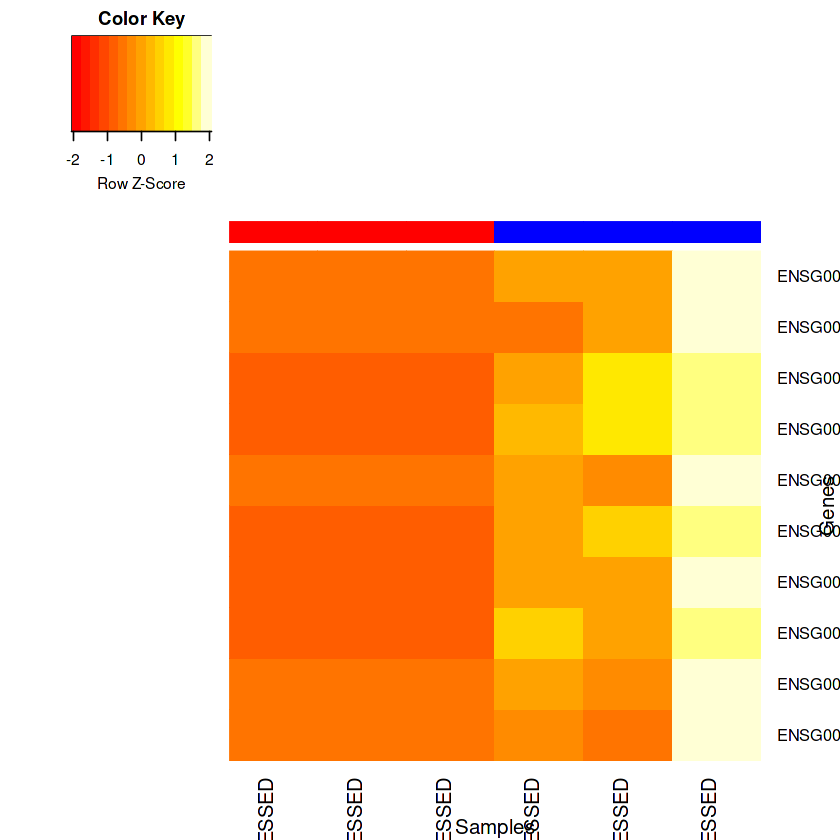

In [48]:
# Isolated reprocessed vs reprocessed dataframe for the top 10 DEGs
gtex_reprocessedVSgdc_reprocessed_counts.df.top10 <- gtex_reprocessedVSgdc_reprocessed_counts.df[rownames(gtex_reprocessedVSgdc_reprocessed_counts.df) %in% reprocessedvsreprocessed.ensembl,]

# Display the dataframe with the top 10 DEGs in ascending padj value order
gtex_reprocessedVSgdc_reprocessed_counts.df.top10 <- gtex_reprocessedVSgdc_reprocessed_counts.df.top10[match(reprocessedvsreprocessed.ensembl, rownames(gtex_reprocessedVSgdc_reprocessed_counts.df.top10)),]
gtex_reprocessedVSgdc_reprocessed_counts.df.top10

# Heatmap of those top 10 DEGs
heatmap.2(as.matrix(gtex_reprocessedVSgdc_reprocessed_counts.df.top10), 
          dendrogram = "none", 
          trace="none", 
          density.info="none", 
          scale = "row", 
          ColSideColors = rep(c("blue","red"), each = 3),
          ylab="Genes",
          xlab="Samples")


(Do the same but now with **published vs published**)

,GTExN7MScountsPUBLISHED,GTExNFK9countsPUBLISHED,GTExO5YTcountsPUBLISHED,GDC2821countsPUBLISHED,GDC2828countsPUBLISHED,GDC2839countsPUBLISHED
,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000163464,22593,35852,174617,15,10,18
ENSG00000129226,10202,7746,19071,9,21,4
ENSG00000162747,17242,13249,65857,12,38,20
ENSG00000132522,2803,2359,4581,68,49,61
ENSG00000182196,1411,1954,3822,28,20,18
ENSG00000219200,5381,4522,18185,81,71,66
ENSG00000157551,2193,3880,13620,18,15,10
ENSG00000170296,13073,11106,59136,28,69,25
ENSG00000236438,1374,898,2552,29,32,28


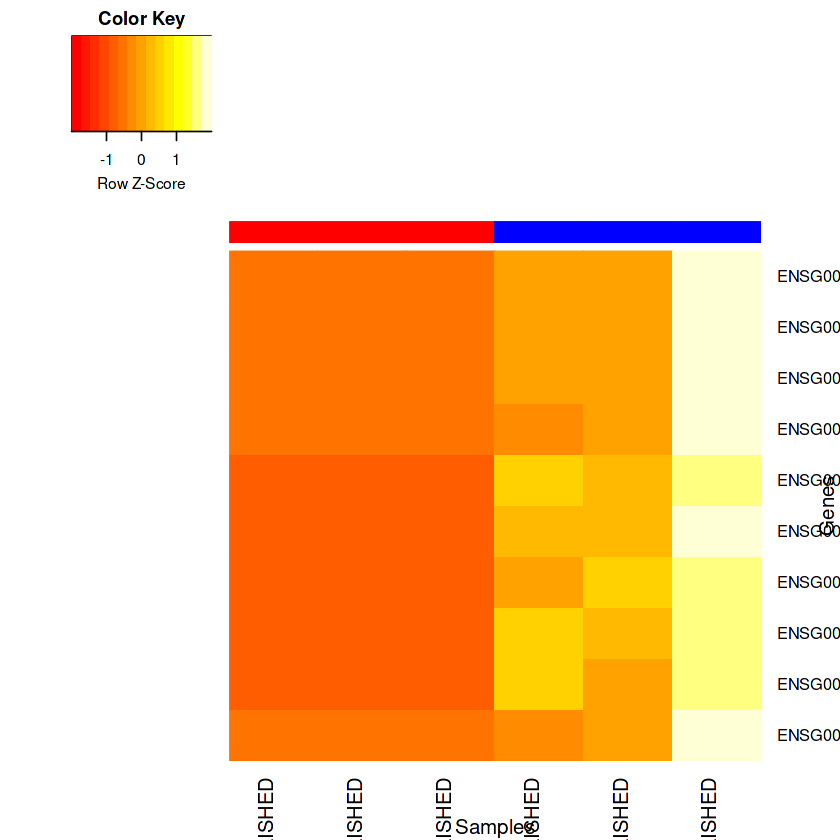

In [49]:
# Isolated published vs published dataframe for the top 10 DEGs
gtex_publishedVSgdc_published_counts.df.top10 <- gtex_publishedVSgdc_published_counts.df[rownames(gtex_publishedVSgdc_published_counts.df) %in% publishedvspublished.ensembl,]

# Display the dataframe with the top 10 DEGs in ascending padj value order
gtex_publishedVSgdc_published_counts.df.top10 <- gtex_publishedVSgdc_published_counts.df.top10[match(publishedvspublished.ensembl, rownames(gtex_publishedVSgdc_published_counts.df.top10)),]
gtex_publishedVSgdc_published_counts.df.top10

# Heatmap of those top 10 DEGs
heatmap.2(as.matrix(gtex_publishedVSgdc_published_counts.df.top10), 
          dendrogram = "none", 
          trace="none", 
          density.info="none", 
          scale = "row", 
          ColSideColors = rep(c("blue","red"), each = 3),
          ylab="Genes",
          xlab="Samples")

## Rankings table for all DEGs

DEGs for both **reprocessed vs reprocessed** and **published vs published** are listed in their tables.

**Steps:**

1) Isolate the DESeq2 results dataframes to have only DEGs listed (alpha = 0.01)

2) Select only the padj column in the dataframes

3) Revert the row names (genes) back as a column in the dataframe

4) Set the rank of each gene in both dataframes as their own columns (start with 1 at the top)

5) Get the symbols of the genes listed (from `Gencode v36 gene ensembl and symbols.csv`) and store as a column in both dataframes

6) Calculate the rank change between the two dataframes for each gene (NA if gene not listed in original dataframes)
 - Cross-reference with original dataframes of all listed genes (55617 genes for published vs published, 60616 genes for reprocessed vs reprocessed), which these dataframes are already ordered by padj value (ascending).
 - **Genes listed are filtered out if they have padj value of "NA" (currently listed at the end of the gene list)**
 - **Genes not listed in the other list of genes (or genes listed have "NA" padj values) are left as "NA"**

8697 DEGs listed for published vs published

7150 DEGs listed for reprocessed vs reprocessed

In [50]:
# 1 and 2: Isolate to only DEGs listed, and select padj column
publishedvspublished.degs_ranked <- gtex_publishedVSgdc_published_counts.dds.res.df  %>% filter(padj < 0.01)  %>% dplyr::select(padj)
reprocessedvsreprocessed.degs_ranked <- gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df  %>% filter(padj < 0.01)  %>% dplyr::select(padj)

# 3: Set row names (gene) as a column
publishedvspublished.degs_ranked <- tibble::rownames_to_column(publishedvspublished.degs_ranked, "gene")
reprocessedvsreprocessed.degs_ranked <- tibble::rownames_to_column(reprocessedvsreprocessed.degs_ranked, "gene")

# 4: Set the rank of each gene as a column
publishedvspublished.degs_ranked$rank <- seq.int(nrow(publishedvspublished.degs_ranked))
reprocessedvsreprocessed.degs_ranked$rank <- seq.int(nrow(reprocessedvsreprocessed.degs_ranked))

# 5: Get the gene symbols as a column
publishedvspublished.degs_ranked <- merge(publishedvspublished.degs_ranked, genes.df, by = "gene", all.x = T)
reprocessedvsreprocessed.degs_ranked <- merge(reprocessedvsreprocessed.degs_ranked, genes.df, by = "gene", all.x = T)
publishedvspublished.degs_ranked <- publishedvspublished.degs_ranked %>% mutate(symbol = ifelse(is.na(symbol), "", symbol))
reprocessedvsreprocessed.degs_ranked <- reprocessedvsreprocessed.degs_ranked %>% mutate(symbol = ifelse(is.na(symbol), "", symbol))

# reset ordering by ranks
publishedvspublished.degs_ranked <- publishedvspublished.degs_ranked  %>% arrange(rank)
reprocessedvsreprocessed.degs_ranked <- reprocessedvsreprocessed.degs_ranked  %>% arrange(rank)

# 6: Get rank change for each gene between published vs published and reprocessed vs reprocessed rankngs
# Function to return rank change for lapply
rank_change <- function(gene, gene_list) {
    if (gene %in% gene_list) {
        return(which(gene_list == gene))
    } else {
        return(NA)
    }
}
# Get list of genes from DESeq2 results dataframe (already orderd by padj value), filter out NA padj values
gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df.NAfiltered <- rownames(gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df  %>% filter(!is.na(padj)))
gtex_publishedVSgdc_published_counts.dds.res.df.NAfiltered <- rownames(gtex_publishedVSgdc_published_counts.dds.res.df %>% filter(!is.na(padj)))
# Get ranking changes and store as columns
publishedtoreprocessed.rankchange <- unlist(lapply(publishedvspublished.degs_ranked$gene, rank_change, gene_list = gtex_reprocessedVSgdc_reprocessed_counts.dds.res.df.NAfiltered))
for (i in 1:length(publishedtoreprocessed.rankchange)) {
    publishedtoreprocessed.rankchange[i] <- publishedtoreprocessed.rankchange[i] - i
}
reprocessedtopublished.rankchange <- unlist(lapply(reprocessedvsreprocessed.degs_ranked$gene, rank_change, gene_list = gtex_publishedVSgdc_published_counts.dds.res.df.NAfiltered))
for (i in 1:length(reprocessedtopublished.rankchange)) {
    reprocessedtopublished.rankchange[i] <- reprocessedtopublished.rankchange[i] - i
}
publishedvspublished.degs_ranked$rank_change <- publishedtoreprocessed.rankchange
reprocessedvsreprocessed.degs_ranked$rank_change <- reprocessedtopublished.rankchange

# Current ordering: gene, padj, rank, symbol, rank_changee
# Re-order the dataframe columns
publishedvspublished.degs_ranked <- publishedvspublished.degs_ranked[, c(2, 1, 4, 3, 5)]
reprocessedvsreprocessed.degs_ranked <- reprocessedvsreprocessed.degs_ranked[, c(2, 1, 4, 3, 5)]
reprocessedvsreprocessed.degs_ranked.reversed <- reprocessedvsreprocessed.degs_ranked[, c(5, 3, 4, 1, 2)]

In [51]:
publishedvspublished.degs_ranked
reprocessedvsreprocessed.degs_ranked

padj,gene,symbol,rank,rank_change
<dbl>,<chr>,<chr>,<int>,<int>
5.980541e-70,ENSG00000163464,CXCR1,1,0
2.666450e-57,ENSG00000129226,CD68,2,26180
1.664413e-56,ENSG00000162747,FCGR3B,3,-1
2.327076e-56,ENSG00000132522,GPS2,4,20906
7.129618e-56,ENSG00000182196,ARL6IP4,5,19617
5.240432e-51,ENSG00000219200,RNASEK,6,379
6.392809e-46,ENSG00000157551,KCNJ15,7,-4
3.343693e-45,ENSG00000170296,GABARAP,8,10206
1.308452e-43,ENSG00000236438,FAM157A,9,-5


padj,gene,symbol,rank,rank_change
<dbl>,<chr>,<chr>,<int>,<int>
5.261007e-69,ENSG00000163464,CXCR1,1,0
1.905767e-56,ENSG00000162747,FCGR3B,2,1
6.679871e-45,ENSG00000157551,KCNJ15,3,4
7.418116e-44,ENSG00000236438,FAM157A,4,5
4.539977e-36,ENSG00000184106,TREML3P,5,13
5.454716e-36,ENSG00000198858,R3HDM4,6,15
6.408991e-36,ENSG00000135083,CCNJL,7,10
7.047980e-30,ENSG00000148346,LCN2,8,16
2.648026e-26,ENSG00000090238,YPEL3,9,35


In [52]:
# Export the dataframes as csv's
write.csv(publishedvspublished.degs_ranked, "outputs/Published vs Published DEGs ranked.csv", row.names = F)
write.csv(reprocessedvsreprocessed.degs_ranked, "outputs/Reprocessed vs Reprocessed DEGs ranked.csv", row.names = F)
write.csv(reprocessedvsreprocessed.degs_ranked.reversed, "outputs/Reprocessed vs Reprocessed DEGs ranked reversed.csv", row.names = F)

### Extend the tables to include counts

Counts for all 6 samples are included in the extended table.

In [53]:
# 1: Isolate counts dataframe to DEGs rows only
# 2: Change row names in counts dataframe (genes) as columns
# 3: Merge isolated counts dataframe with extended rank table
# 4: Reorder rows by gene rankings

# published vs published table
gtex_publishedVSgdc_published_counts.df.all <- gtex_publishedVSgdc_published_counts.df[rownames(gtex_publishedVSgdc_published_counts.df) %in% publishedvspublished.degs_ranked$gene,]
gtex_publishedVSgdc_published_counts.df.all <- tibble::rownames_to_column(gtex_publishedVSgdc_published_counts.df.all, "gene")
publishedvspublished.degs_ranked.all <- merge(gtex_publishedVSgdc_published_counts.df.all, publishedvspublished.degs_ranked, by = "gene", all.x = T)
publishedvspublished.degs_ranked.all <- publishedvspublished.degs_ranked.all  %>% arrange(rank)

# reprocessed vs reprocessed table
gtex_reprocessedVSgdc_reprocessed_counts.df.all <- gtex_reprocessedVSgdc_reprocessed_counts.df[rownames(gtex_reprocessedVSgdc_reprocessed_counts.df) %in% reprocessedvsreprocessed.degs_ranked$gene,]
gtex_reprocessedVSgdc_reprocessed_counts.df.all <- tibble::rownames_to_column(gtex_reprocessedVSgdc_reprocessed_counts.df.all, "gene")
reprocessedvsreprocessed.degs_ranked.all <- merge(gtex_reprocessedVSgdc_reprocessed_counts.df.all, reprocessedvsreprocessed.degs_ranked, by = "gene", all.x = T)
reprocessedvsreprocessed.degs_ranked.all <- reprocessedvsreprocessed.degs_ranked.all  %>% arrange(rank)

publishedvspublished.degs_ranked.all
reprocessedvsreprocessed.degs_ranked.all

gene,GTExN7MScountsPUBLISHED,GTExNFK9countsPUBLISHED,GTExO5YTcountsPUBLISHED,GDC2821countsPUBLISHED,GDC2828countsPUBLISHED,GDC2839countsPUBLISHED,padj,symbol,rank,rank_change
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<int>,<int>
ENSG00000163464,22593,35852,174617,15,10,18,5.980541e-70,CXCR1,1,0
ENSG00000129226,10202,7746,19071,9,21,4,2.666450e-57,CD68,2,26180
ENSG00000162747,17242,13249,65857,12,38,20,1.664413e-56,FCGR3B,3,-1
ENSG00000132522,2803,2359,4581,68,49,61,2.327076e-56,GPS2,4,20906
ENSG00000182196,1411,1954,3822,28,20,18,7.129618e-56,ARL6IP4,5,19617
ENSG00000219200,5381,4522,18185,81,71,66,5.240432e-51,RNASEK,6,379
ENSG00000157551,2193,3880,13620,18,15,10,6.392809e-46,KCNJ15,7,-4
ENSG00000170296,13073,11106,59136,28,69,25,3.343693e-45,GABARAP,8,10206
ENSG00000236438,1374,898,2552,29,32,28,1.308452e-43,FAM157A,9,-5


gene,GTExN7MScountsREPROCESSED,GTExNFK9countsREPROCESSED,GTExO5YTcountsREPROCESSED,GDC2821countsREPROCESSED,GDC2828countsREPROCESSED,GDC2839countsREPROCESSED,padj,symbol,rank,rank_change
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<int>,<int>
ENSG00000163464,12193,20430,95467,15,10,18,5.261007e-69,CXCR1,1,0
ENSG00000162747,9192,7385,35265,12,38,20,1.905767e-56,FCGR3B,2,1
ENSG00000157551,1227,2227,7541,18,15,10,6.679871e-45,KCNJ15,3,4
ENSG00000236438,935,549,1788,29,30,29,7.418116e-44,FAM157A,4,5
ENSG00000184106,311,288,957,6,7,5,4.539977e-36,TREML3P,5,13
ENSG00000198858,22229,12733,33248,1944,1724,1560,5.454716e-36,R3HDM4,6,15
ENSG00000135083,835,1353,2630,29,16,7,6.408991e-36,CCNJL,7,10
ENSG00000148346,7056,871,28306,12,15,14,7.047980e-30,LCN2,8,16
ENSG00000090238,7631,5230,10759,1328,847,984,2.648026e-26,YPEL3,9,35


In [54]:
# Export the dataframes as csv's
write.csv(publishedvspublished.degs_ranked.all, "outputs/Published vs Published DEGs ranked extended.csv", row.names = F)
write.csv(reprocessedvsreprocessed.degs_ranked.all, "outputs/Reprocessed vs Reprocessed DEGs ranked extended.csv", row.names = F)

## Extra: Get number of "NA"s in the rank change columns

As explained above:

- **Genes listed are filtered out if they have padj value of "NA" (currently listed at the end of the gene list)**
- **Genes not listed in the other list of genes (or genes listed have "NA" padj values) are left as "NA"**

In [55]:
sum(is.na(publishedvspublished.degs_ranked.all$rank_change))
sum(is.na(reprocessedvsreprocessed.degs_ranked.all$rank_change))

[1] 120

[1] 250

**Number of Genes listed in original analysis:**
- Published vs Published: 55617 genes
- Reprocessed vs Reprocessed: 60616 genes

**Number of DEGs listed by DESeq2:**
- Published vs Published: 8697 genes
- Reprocessed vs Reprocessed: 7150 genes

**Number of NA's listed in Rank Change columns:**
- Published vs Published: 209 genes
- Reprocessed vs Reprocessed: 302 genes

## Extra: Make table for DEGs with "NA" rank changes

In [56]:
write.csv(publishedvspublished.degs_ranked.all[is.na(publishedvspublished.degs_ranked.all$rank_change),], "outputs/Published vs Published DEGs ranked extended NA rank changes.csv", row.names = F)
write.csv(reprocessedvsreprocessed.degs_ranked.all[is.na(reprocessedvsreprocessed.degs_ranked.all$rank_change),], "outputs/Reprocessed vs Reprocessed DEGs ranked extended NA rank changes.csv", row.names = F)